In [1]:
# import modules
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import json
import h5py
import sys
sys.path.append('/home/jannik/PhD/MA/master-code')

from master_code import *

from scipy import signal
from scipy import interpolate

/home/jannik/anaconda3/envs/dolphin/lib/python3.10/site-packages/gwtools/const.py:52: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
Loaded NRSur7dq4Remnant fit.
Loaded NRSur7dq4 model


In [2]:
def access_SXS_metadata(file_directory):
    
    metadata_path = file_directory + '/metadata.json'
    with open(metadata_path) as file: 
        metadata = json.load(file)
        
    q = metadata['reference_mass_ratio']
    chi1 = metadata['reference_dimensionless_spin1']
    chi2 = metadata['reference_dimensionless_spin2']
    f_ref_orb = np.linalg.norm(metadata['reference_orbital_frequency'])
    t_peak = metadata['common_horizon_time']
    t_ref = metadata['reference_time']
    
    return q, chi1, chi2, f_ref_orb, t_peak, t_ref

In [3]:
def create_SXS_hlm_dict(file_directory):
    
    # load rhM file
    rh_data = h5py.File(file_directory + '/rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r')
    
    # get shifted and sliced time from 2,2 mode
    q, chi1, chi2, f_ref_orb, t_peak, t_ref = access_SXS_metadata(file_directory)
    t_SXS = rh_data['Extrapolated_N2.dir']['Y_l2_m2.dat'][:,0]
    idx_cut = np.argmin(np.abs(t_SXS - t_ref))
    t = (t_SXS - t_peak)[idx_cut:] 
    
    # get sliced mode array dictonary
    ell_min = 2
    ell_max = 4
    mode_list = [(ell,m) for ell in range(ell_min, ell_max+1) for m in range(-ell,ell+1)]
    hlm = []
    for lm in mode_list:
        l = str(lm[0])
        m = str(lm[1])
        idx = 'Extrapolated_N4.dir/Y_l'+l+'_m'+m+'.dat'
        rh = rh_data[idx][:,1] + 1j*rh_data[idx][:,2] 
        hlm.append(rh[idx_cut:])
    h = dict(zip(mode_list, hlm))
    
    return t, h

In [4]:
# configuration

file_directory = 'datafiles/SXSfiles/0802' 

q, chi1, chi2, f_ref_orb, t_peak, t_ref = access_SXS_metadata(file_directory) 

print(q)
print(chi1)
print(chi2)
print(f_ref_orb) 
print(t_peak)
print(t_ref)

1.999808349834873
[0.580481506476, 0.00851891091271, -0.550256942689]
[-0.0245551171923, -0.0740562971457, 0.795951694216]
0.016379876502918018
4966.33536108
640.0


In [5]:
# calculate waveform from SXS
                  
t, h_iner = create_SXS_hlm_dict(file_directory)
h_copr = modes_from_iner_to_new_frame(t, h_iner, frame='coprecessing')
h_coro = modes_from_iner_to_new_frame(t, h_iner, frame='corotating')

print(np.max(ampl_asym(h_iner, 2,2)))

0.08259575381199265


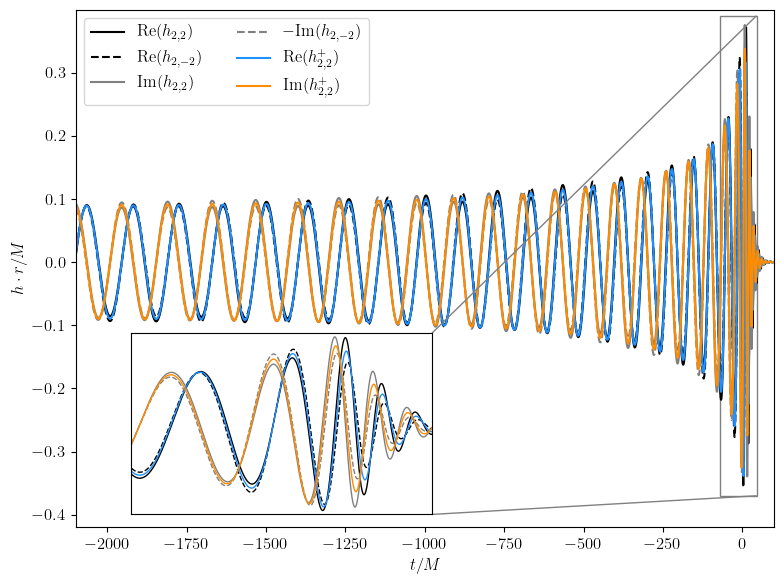

In [6]:
# setup plotting
fig = plt.figure()
ax1 = fig.add_subplot(111)
axins = ax1.inset_axes([0.08, 0.025, 0.43, 0.35])


# full plot 
ax1.plot(t, np.real(h_iner[2,2]), color='black' , label=r'Re$(h_{2,2})$')
ax1.plot(t, np.real(h_iner[2,-2]),'--', color='black' , label=r'Re$(h_{2,-2})$')
ax1.plot(t, np.imag(h_iner[2,2]), color='grey' , label=r'Im$(h_{2,2})$')
ax1.plot(t, -np.imag(h_iner[2,-2]),'--', color='grey' , label=r'$-$Im$(h_{2,-2})$')
ax1.plot(t, np.real(h_sym(h_iner, 2, 2)), color='dodgerblue',label=r'Re$(h_{2,2}^+)$')
ax1.plot(t, np.imag(h_sym(h_iner, 2, 2)), color='darkorange',label=r'Im$(h_{2,2}^+)$')

ax1.set_ylabel('$h\cdot r/M$')
ax1.set_xlabel('$t/M$')
ax1.legend(loc='upper left', ncol=2)
ax1.set_xlim(-2100,100)
ax1.set_ylim(-0.42,0.399)


# inset plot
axins.plot(t, np.real(h_iner[2,2]), color='black', linewidth=1)
axins.plot(t, np.real(h_iner[2,-2]),'--', color='black' , linewidth=1)
axins.plot(t, np.imag(h_iner[2,2]), color='grey', linewidth=1)
axins.plot(t, -np.imag(h_iner[2,-2]),'--', color='grey', linewidth=1)
axins.plot(t, np.real(h_sym(h_iner, 2, 2)), color='dodgerblue', linewidth=1)
axins.plot(t, np.imag(h_sym(h_iner, 2, 2)), color='darkorange', linewidth=1)

x1, x2, y1, y2 = -70, 45, -.37, .39 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax1, axins, loc1=4, loc2=1, fc="none", ec="0.5")

fig.tight_layout()
#fig.savefig('re_im_sym_modes.pdf')
plt.show()

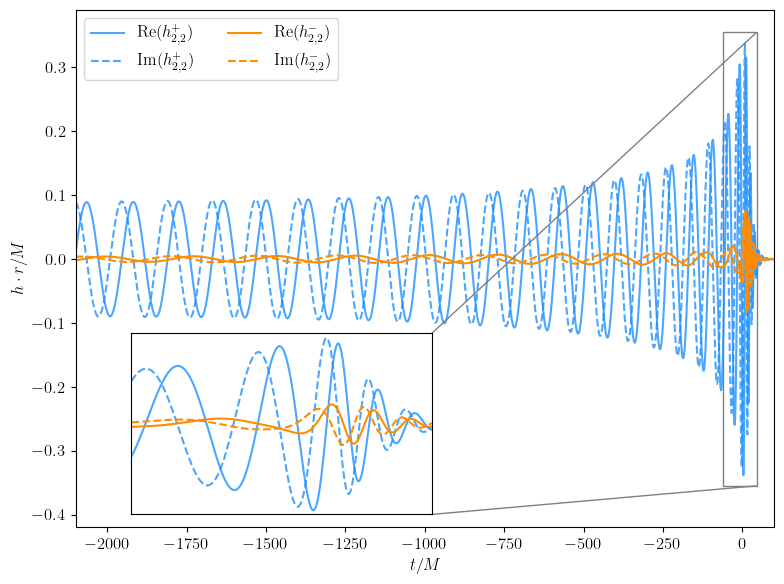

In [7]:
# setup plotting
fig = plt.figure()
ax1 = fig.add_subplot(111)
axins = ax1.inset_axes([0.08, 0.025, 0.43, 0.35])


# full plot 
ax1.plot(t, np.real(h_sym(h_iner, 2, 2)), color='dodgerblue', alpha=0.8, label=r'Re$(h_{2,2}^+)$')
ax1.plot(t, np.imag(h_sym(h_iner, 2, 2)), '--', color='dodgerblue', alpha=0.8, label=r'Im$(h_{2,2}^+)$')
ax1.plot(t, np.real(h_asym(h_iner, 2, 2)), color='darkorange', label=r'Re$(h_{2,2}^-)$')
ax1.plot(t, np.imag(h_asym(h_iner, 2, 2)), '--', color='darkorange', label=r'Im$(h_{2,2}^-)$')

ax1.set_ylabel('$h\cdot r/M$')
ax1.set_xlabel('$t/M$')
ax1.legend(loc='upper left', ncol=2)
ax1.set_xlim(-2100,100)
ax1.set_ylim(-0.42,0.39)


# inset plot
axins.plot(t, np.real(h_sym(h_iner, 2, 2)), color='dodgerblue', alpha=0.8)
axins.plot(t, np.imag(h_sym(h_iner, 2, 2)), '--', color='dodgerblue', alpha=0.8)
axins.plot(t, np.real(h_asym(h_iner, 2, 2)), color='darkorange')
axins.plot(t, np.imag(h_asym(h_iner, 2, 2)), '--', color='darkorange')

x1, x2, y1, y2 = -60, 45, -.355, .355 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax1, axins, loc1=4, loc2=1, fc="none", ec="0.5")

fig.tight_layout()
#fig.savefig('re_im_sym_vs_asym.pdf')
plt.show()

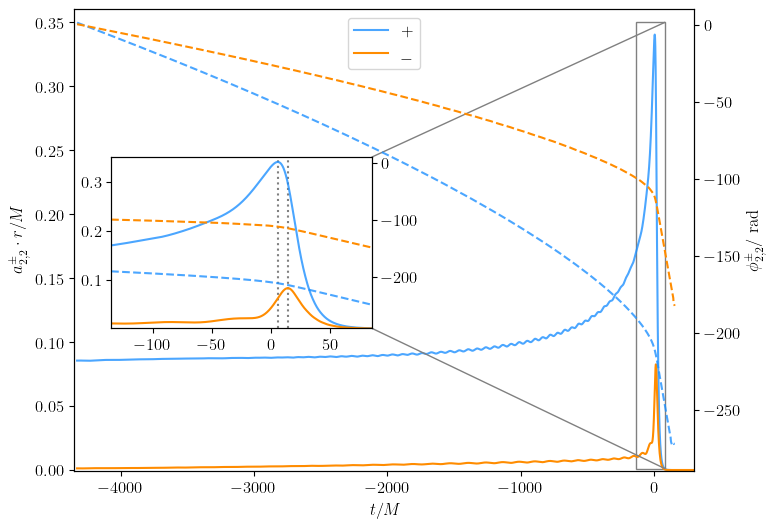

In [8]:
# setup plotting
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
axins = ax1.inset_axes([0.06, 0.31, 0.42, 0.37])
axins2 = axins.twinx()

# plot amplitudes
ax1.plot(t, ampl_sym(h_iner, 2, 2), color='dodgerblue', alpha=0.8, label=r'$+$')
ax1.plot(t, ampl_asym(h_iner, 2, 2), color='darkorange',label=r'$-$')
ax1.set_ylabel(r'$a_{2,2}^\pm\cdot r/M$')
ax1.set_ylim(-0.001,0.36)
ax1.set_xlim(-4350,300)
ax1.set_xlabel('$t/M$')
ax1.hlines(y=0., xmin=100, xmax=300, color='darkorange')
ax1.legend(loc='upper center')

# plot phase
ax2.plot(t, phi_sym(h_iner, 2, 2),'--', color='dodgerblue', alpha=0.8)
ax2.plot(t, phi_asym(h_iner, 2, 2),'--', color='darkorange')
ax2.set_ylabel(r'$\phi_{2,2}^\pm/$ rad')
ax2.set_ylim(-290, 10)

# plot inset
x1, x2, y1, y2 = -135, 85, .001, .35 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
mark_inset(ax1, axins, loc1=4, loc2=1, fc="none", ec="0.5")
axins.axvline(t[np.argmax(ampl_asym(h_iner, 2, 2))], linestyle=':', color='grey')
axins.axvline(t[np.argmax(ampl_sym(h_iner, 2, 2))], linestyle=':', color='grey')
axins.plot(t, ampl_sym(h_iner, 2, 2), color='dodgerblue', alpha=0.8, label=r'$+$')
axins.plot(t, ampl_asym(h_iner, 2, 2), color='darkorange',label=r'$-$')
axins.hlines(y=0., xmin=100, xmax=300, color='darkorange')
axins2.plot(t, phi_sym(h_iner, 2, 2),'--', color='dodgerblue', alpha=0.8)
axins2.plot(t, phi_asym(h_iner, 2, 2),'--', color='darkorange')
axins2.set_ylim(-290, 10)

#fig.savefig('ampl_phase_sym_asym.pdf')
plt.show()

In [9]:
t[np.argmax(ampl_asym(h_iner, 2, 2))]

14.272039132058126

In [10]:
t[np.argmax(ampl_sym(h_iner, 2, 2))]

5.773658463387619

In [11]:
np.max(ampl_asym(h_iner, 2, 2))/np.max(ampl_sym(h_iner, 2, 2))

0.24272688106663762

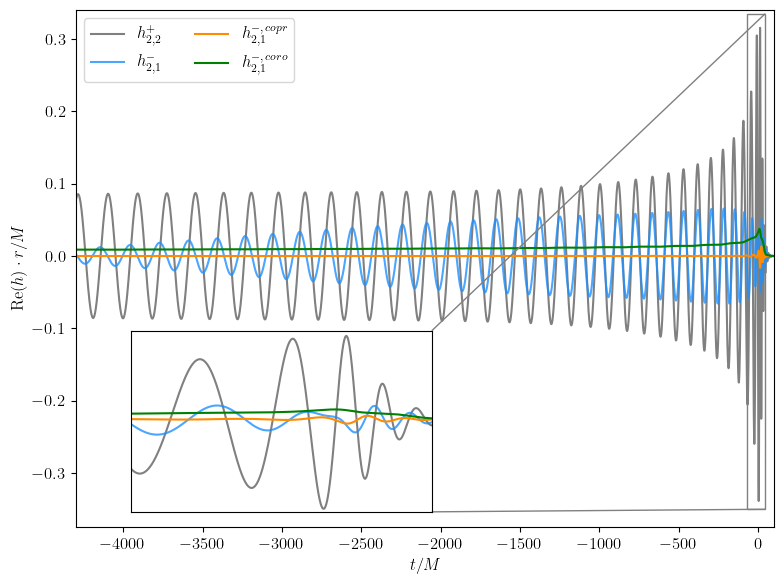

In [12]:
# setup plotting
fig = plt.figure()
ax1 = fig.add_subplot(111)
axins = ax1.inset_axes([0.08, 0.03, 0.43, 0.35])

# full plot 
ax1.plot(t, np.real(h_sym(h_iner, 2, 2)), color='grey', label=r'$h_{2,2}^+$')
ax1.plot(t, np.real(h_asym(h_iner, 2, 1)), color='dodgerblue', alpha=0.8, label=r'$h_{2,1}^-$')
ax1.plot(t, np.real(h_asym(h_copr, 2, 1)), color='darkorange', label=r'$h_{2,1}^{-,\,copr}$')
ax1.plot(t, np.real(h_asym(h_coro, 2, 1)), color='green', label=r'$h_{2,1}^{-,\,coro}$')

ax1.set_ylabel('Re$(h)\cdot r/M$')
ax1.set_xlabel('$t/M$')
ax1.legend(loc='upper left', ncol=2)
ax1.set_xlim(-4300,100)
ax1.set_ylim(-0.375,0.34)

# inset plot
axins.plot(t, np.real(h_sym(h_iner, 2, 2)), color='grey')
axins.plot(t, np.real(h_asym(h_iner, 2, 1)), color='dodgerblue', alpha=0.8)
axins.plot(t, np.real(h_asym(h_copr, 2, 1)), color='darkorange')
axins.plot(t, np.real(h_asym(h_coro, 2, 1)), color='green')

x1, x2, y1, y2 = -70, 45, -.35, .335 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax1, axins, loc1=4, loc2=1, fc="none", ec="0.5")

fig.tight_layout()
#fig.savefig('re_21_frames.pdf')
plt.show()

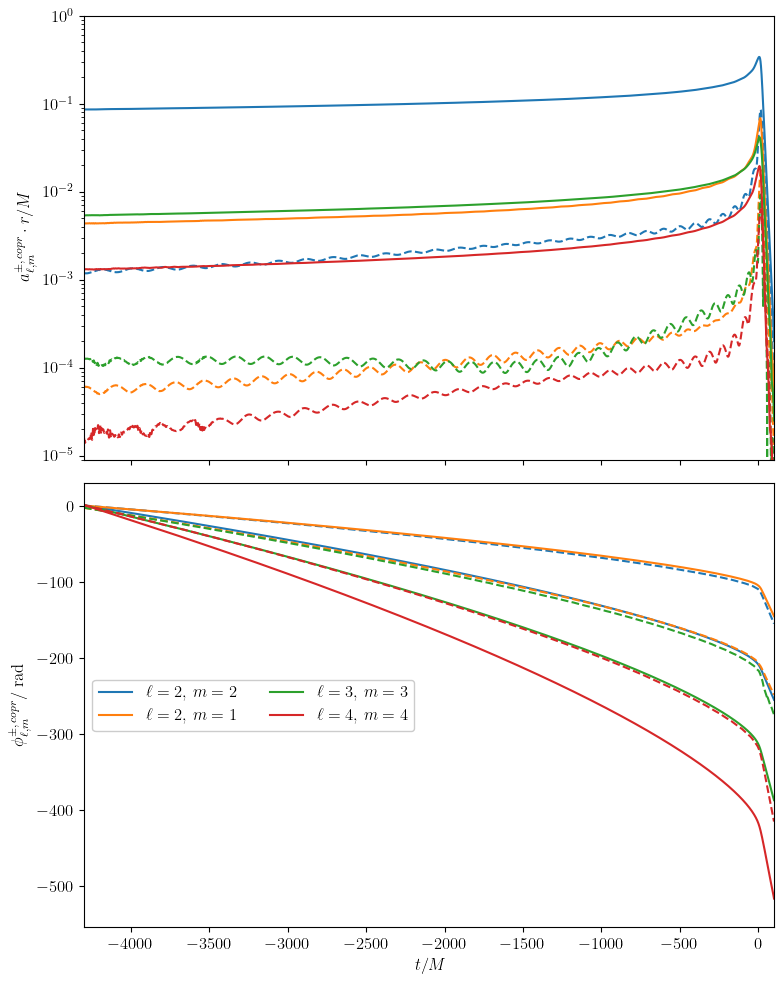

In [13]:
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)

mode_list_m_pos = [[2,2], [2,1], [3,3], [4,4]]# [3,1], [4,4], [4,3], [4,2], [4,1]]

for mode in mode_list_m_pos:
    
    # amplitude
    ampl_s = ampl_sym(h_copr, mode[0], mode[1])
    ampl_a = ampl_asym(h_copr, mode[0], mode[1])
    line, = ax1.semilogy(t, ampl_s)
    ax1.semilogy(t, ampl_a, linestyle='--', color=line.get_color())
    
    # phase
    phi_s = phi_sym(h_copr, mode[0], mode[1])
    phi_a = phi_asym(h_copr, mode[0], mode[1])
    line, = ax2.plot(t, phi_s, label='$\ell=%s,\,m=%s$' %(mode[0], mode[1]))
    ax2.plot(t, phi_a, linestyle='--', color=line.get_color())

ax1.set_ylabel('$a_{\ell,m}^{\pm,\,copr}\cdot r/M$')
ax1.set_ylim(0.9*1e-5, 1)
ax1.tick_params('x', labelbottom=False)
ax1.set_xlim(-4300, 100)

ax2.set_ylabel(r'$\phi_{\ell,m}^{\pm,\,copr}/$ rad')
ax2.set_xlabel('$t/M$')
ax2.legend(loc='center left', framealpha=1, ncol=2)

fig.tight_layout()
#fig.savefig('ampl_phase_subdom.pdf')
plt.show()

### Frequency Domain

In [51]:
def fourier_filter_mode(t, hlm):
    
    # get uniform time steps
    dt = np.min(np.diff(t))
    t_uniform = np.arange(t[0], t[-1], dt)

    # interpolate to uniform time
    hlm_ip1d = interpolate.interp1d(t, hlm, kind='cubic') 
    h = hlm_ip1d(t_uniform)
    
    # apply Tukey window
    window = signal.windows.tukey(len(h), alpha=0.015, sym=True)
    h *= window
    
    # Fourier trafo
    hf = np.fft.fftshift(np.fft.fft(h))*dt
    freq = np.fft.fftshift(np.fft.fftfreq(len(t_uniform), dt))
    freq *= -1
    
    return freq, hf

In [52]:
# define asymmetry in frequency domain
def h_asym_22_f(h, t):
    
    freq, h22f = fourier_filter_mode(t, h[(2,2)])
    freq, h2m2f = fourier_filter_mode(t, h[(2,-2)])
    
    ch2m2mf = np.conjugate(np.flip(h2m2f))

    return freq, (h22f - ch2m2mf)/2, (h22f + ch2m2mf)/2

f, hasymf, hsymf = h_asym_22_f(h_copr, t)

In [53]:
# calculate orbital frequency

dt = np.min(np.diff(t))
t_uniform = np.arange(t[0], t[-1], dt)
hlm_ip1d = interpolate.interp1d(t, h_copr[(2,2)], kind='cubic') 
h22 = hlm_ip1d(t_uniform)
hlm_ip1d = interpolate.interp1d(t, h_copr[(2,-2)], kind='cubic') 
h2m2 = hlm_ip1d(t_uniform)

arg22 = np.unwrap(np.angle(h22))
arg2m2 = np.unwrap(np.angle(h2m2))

phi_orb = 1/4 * (arg22 - arg2m2)

phi_orb_dot = np.diff(phi_orb) / dt
phi_orb_dot = -np.append(phi_orb_dot[0], phi_orb_dot)

In [54]:
# get ringdown frequency and freq at 0
print(phi_orb_dot[0])
print(f_ref_orb)

i0 = np.argmin(np.abs(t_uniform))
t_stable = 60
istable = np.argmin(np.abs(t_uniform - t_stable))

f0 = phi_orb_dot[i0]/np.pi
frd = phi_orb_dot[istable]/np.pi

print(f0)
print(frd)

0.016386984421760075
0.016379876502918018
0.04399353139074333
0.07845583469072946


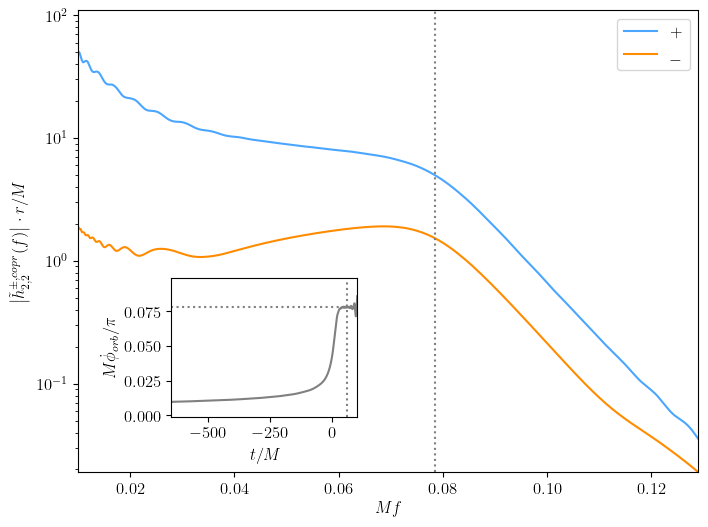

In [66]:
# setup plotting
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
axins = ax1.inset_axes([0.15, 0.12, 0.3, 0.3])

freq, h_minus_f = fourier_filter_mode(t, h_asym(h_iner, 2, 2))
freq, h_plus_f = fourier_filter_mode(t, h_sym(h_iner, 2, 2))

# plot amplitudes
ax1.semilogy(freq, np.abs(h_plus_f), color='dodgerblue', alpha=0.8, label=r'$+$')
ax1.semilogy(freq, np.abs(h_minus_f), color='darkorange', label=r'$-$')
ax1.set_ylabel(r'$\big|\tilde{h}_{2,2}^{\pm,copr} (f)\big|\cdot r/M$')
ax1.set_ylim(1.9*1e-2, 1.1*1e2)
ax1.set_xlim(0.01,0.129)
ax1.set_xlabel('$Mf$')
ax1.legend(loc='upper right')
ax1.axvline(frd, linestyle=':', color='grey')

axins.plot(t_uniform, phi_orb_dot/np.pi, color='grey')
axins.set_ylabel(r'$M\dot{\phi}_{orb}/\pi$')
axins.set_xlabel(r'$t/M$')
axins.set_xlim(-650, 100)
axins.set_ylim(-0.001, .099)
axins.axhline(frd, linestyle=':', color='grey')
axins.axvline(t_stable, linestyle=':', color='grey')

#fig.savefig('fourier_domain.pdf')
plt.show()